In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/app')


# Загрузка данных из файла


In [0]:
data = pd.read_csv('train.tsv', delimiter='\t')

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [0]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


# Анализ данных

## Price

In [0]:
data.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

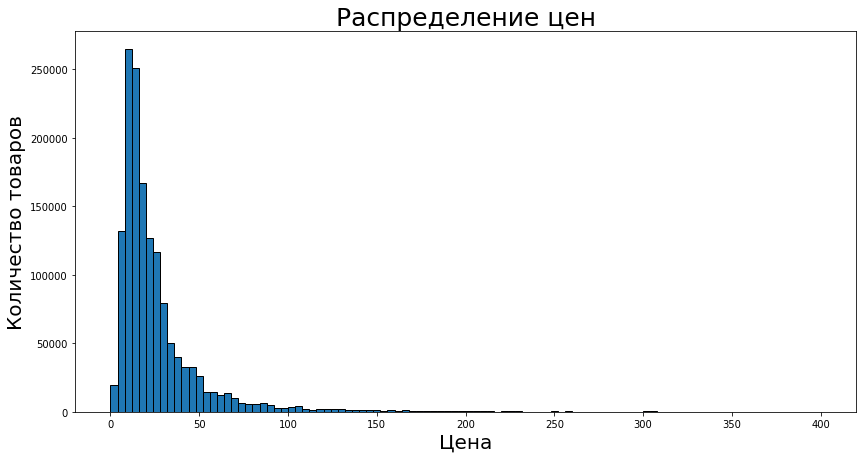

In [0]:
plt.figure(figsize=(14, 7))
plt.hist(data['price'], bins=100, range=[0,400], edgecolor = 'k')
plt.title('Распределение цен', size=25)
plt.xlabel('Цена', size=20)
plt.ylabel('Количество товаров', size=20)
plt.show()

Видим, что распределение цены сильно смещено к минимальной границе (75% всех товаров имеют цену ниже 29 долларов). 
Медианная цена равна 17 долларам.

In [0]:
print('Данные содержат ' + str(len(data[data.price <= 0])) + ' товаров с ценой менее либо равной нуля')

Данные содержат 874 товаров с ценой менее либо равной нуля


Удалим строки с некорректной ценой.

In [0]:
data = data[data.price > 0].reset_index(drop=True)

## Brand_name

Исследуем **brand_name**. Видим, что в сразу же в трех из первых пяти строк бренд не задан(NaN). Посмотрим сколько не задано в процентном соотношении:

In [0]:
def NaN_percentage(dataset, feature_name):
    if not feature_name in data.keys():
        return -1
    return len([x for x in pd.isnull(dataset[feature_name]) if x == True])/data.shape[0]*100

In [0]:
print('Бренд не задан в ' + str(round(NaN_percentage(data, 'brand_name'),2)) + ' %')

Бренд не задан в 42.68 %


Проверим остальные признаки на наличие пропущенных значений:

In [0]:
for k in data.keys(): 
    print('В ' + k +' пропущено ' + str(NaN_percentage(data, k)) + ' %')


В train_id пропущено 0.0 %
В name пропущено 0.0 %
В item_condition_id пропущено 0.0 %
В category_name пропущено 0.42676901388500105 %
В brand_name пропущено 42.675687251902986 %
В price пропущено 0.0 %
В shipping пропущено 0.0 %
В item_description пропущено 0.0002698081326916397 %


Как видим, пропущенные значения присутствуют в brand_name, category_name, item_description.
Так как пропущенные значения в brand_name составляют значительную часть данных, сделаем это отдельной категорией, заменив их на 'none'. Товары с пропущенными значениями в category_name и item_description удалим.

In [0]:
data['brand_name'].fillna('none', inplace=True)
data.dropna(inplace=True)

data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,none,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,none,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,none,44.0,0,Complete with certificate of authenticity


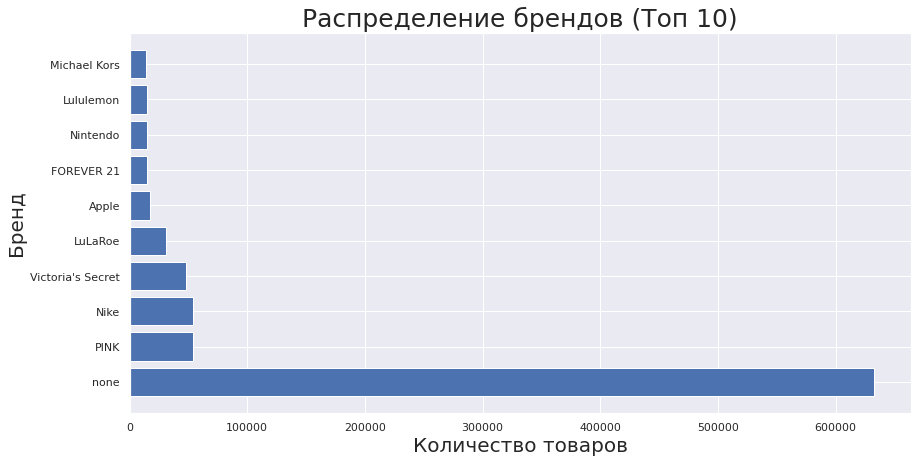

In [0]:
brand_count = Counter(data['brand_name'].values)
x, y = zip(*brand_count.most_common(10))
plt.figure(figsize=[14,7])
plt.barh(x, y)
plt.title('Распределение брендов (Топ 10)', size = 25)
plt.xlabel('Количество товаров', size = 20)
plt.ylabel('Бренд', size = 20)
plt.show()

Можем заметить, что бренд не определен у абсолютного большинства товаров.

Посмотрим, как определенность бренда влияет на цену.

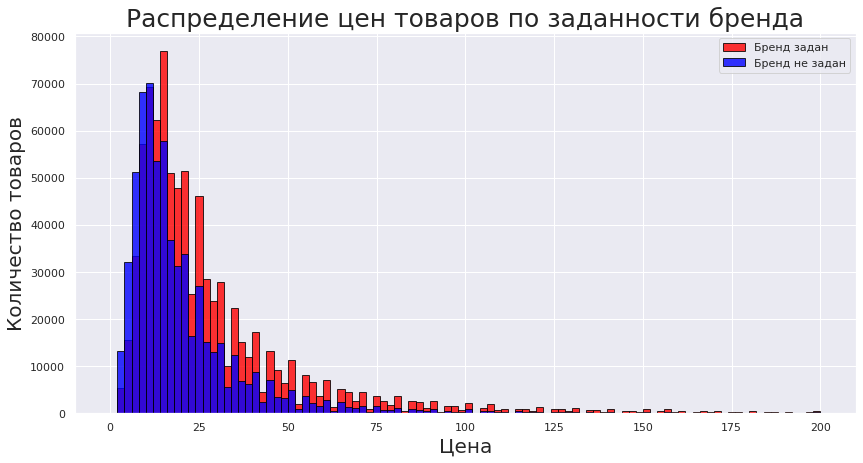

In [0]:
defined_brand_prices = data[data['brand_name']!='none']['price']
none_brand_prices = data[data['brand_name']=='none']['price']

plt.figure(figsize=(14,7))
plt.hist(defined_brand_prices, color='Red', bins=100, range=[0,200], alpha=0.8, label='Бренд задан', edgecolor = 'black')
plt.hist(none_brand_prices, color='Blue', bins=100, range=[0,200], alpha=0.8, label='Бренд не задан', edgecolor = 'black')
plt.title('Распределение цен товаров по заданности бренда', size=25)
plt.xlabel('Цена', size=20)
plt.ylabel('Количество товаров', size=20)
plt.legend()
plt.show()

In [0]:
print('Медианная цена товаров, у которых бренд задан: ' + str(defined_brand_prices.median()))
print('Медианная цена товаров, у которых бренд не задан: ' + str(none_brand_prices.median()))

Медианная цена товаров, у которых бренд задан: 20.0
Медианная цена товаров, у которых бренд не задан: 14.0


Как мы видим, медианная цена товаров заметно выше, если у них задан бренд.

Добавим данный признак в датасет.

In [0]:
brand_is_defined = []
for b in data['brand_name']:
    if b == 'none':
        brand_is_defined.append('0')
    else:
        brand_is_defined.append('1')
data['brand_is_defined'] = brand_is_defined
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,brand_is_defined
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,none,10.0,1,No description yet,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,none,35.0,1,New with tags. Leather horses. Retail for [rm]...,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,none,44.0,0,Complete with certificate of authenticity,0


## Shipping


Исследуем shipping и посмотрим на его связь с ценой.

In [0]:
null_percent = round(data[data['shipping']==0].shape[0]/data.shape[0]*100, 2)
print('0: ' + str(null_percent) + ' %')
print('1: ' + str(100 - null_percent) + ' %')

0: 55.27 %
1: 44.73 %


0 - доставка оплачивается покупателем.

1 - доставка оплачивается продавцом.

То есть, доставка 55% товаров оплачивается покупателем, 45% продавцом.

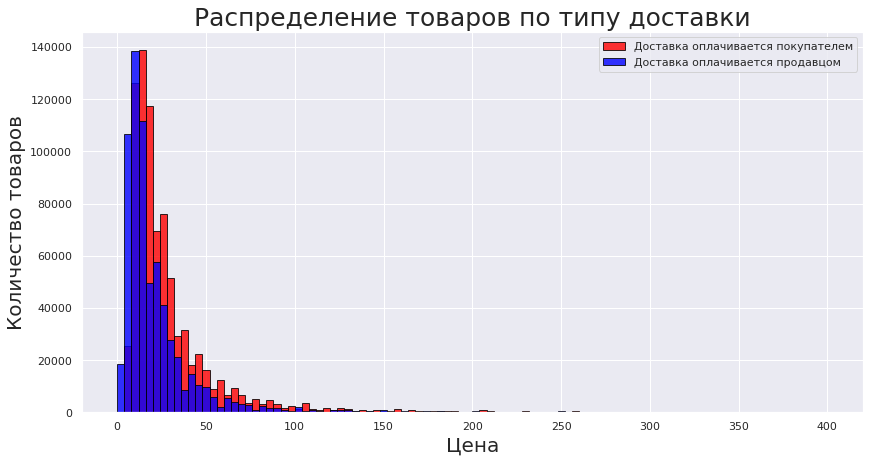

In [0]:
shipping_paid_by_buyer_prices = data[data['shipping']==0]['price']
shipping_paid_by_seller_prices = data[data['shipping']==1]['price']

plt.figure(figsize=(14,7))
plt.hist(shipping_paid_by_buyer_prices, color='Red', bins=100, range=[0,400], alpha=0.8, label='Доставка оплачивается покупателем', edgecolor = 'black')
plt.hist(shipping_paid_by_seller_prices, color='Blue', bins=100, range=[0,400], alpha=0.8, label='Доставка оплачивается продавцом', edgecolor = 'black')
plt.title('Распределение товаров по типу доставки', size=25)
plt.xlabel('Цена', size=20)
plt.ylabel('Количество товаров', size=20)
plt.legend()
plt.show()

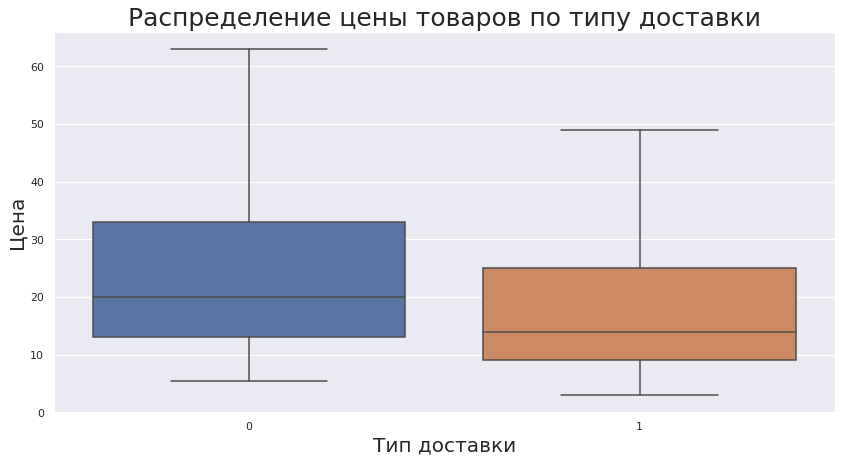

In [0]:
sns.set(style='darkgrid')
plt.figure(figsize=(14,7))
shipping_distr = sns.boxplot(x='shipping', y='price', data=data, showfliers=False)
shipping_distr.set_xlabel('Тип доставки', size=20)
shipping_distr.set_ylabel('Цена', size=20)
plt.title('Распределение цены товаров по типу доставки', size = 25)
plt.show()

In [0]:
print('Медианная цена товаров, доставку которых оплачивает покупатель: ' + str(shipping_paid_by_buyer_prices.median()))
print('Медианная цена товаров, доставку которых оплачивает продавец: ' + str(shipping_paid_by_seller_prices.median()))

Медианная цена товаров, доставку которых оплачивает покупатель: 20.0
Медианная цена товаров, доставку которых оплачивает продавец: 14.0


## Item_condition_id

Исследуем item_condition_id.

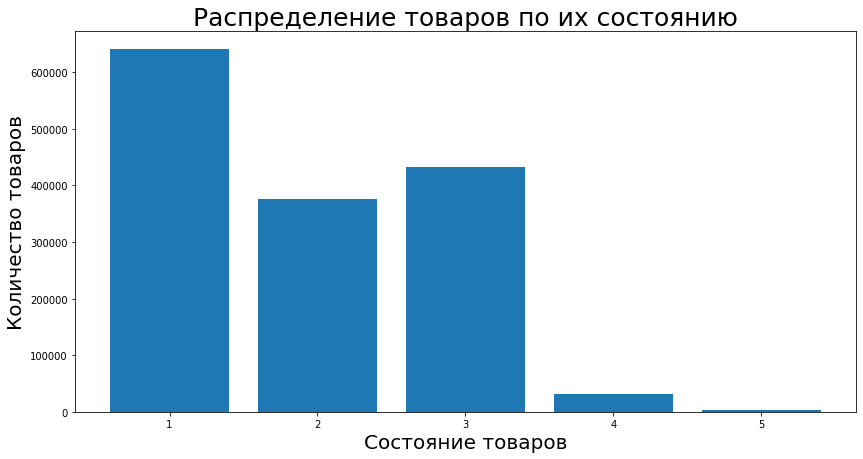

In [0]:
condition_count = Counter(data['item_condition_id'])
x, y = zip(*condition_count.most_common())
plt.figure(figsize=[14,7])
plt.bar(x, y)
plt.title('Распределение товаров по их состоянию', size=25)
plt.xlabel('Состояние товаров', size=20)
plt.ylabel('Количество товаров', size=20)
plt.show()

In [0]:
for i in range(1,6):
    print(str(i) + ': ' + str(round(data[data['item_condition_id']==i].shape[0]/data.shape[0]*100, 2)) + ' %')

1: 43.21 %
2: 25.33 %
3: 29.15 %
4: 2.16 %
5: 0.16 %


Состояние товаров оценивается в диапазоне [1..5], где 1 - самое лучшее состояние, 5 - худшее.

Таким образом, можем отметить, что большинство продавцов оценили состояние своего товара как наилучшее.
И только 0.16% товаров имеют указанное худшее состояние.

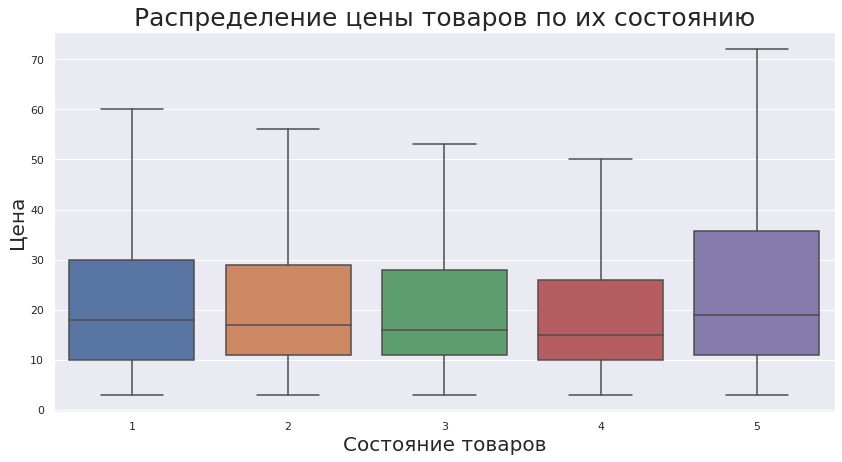

In [0]:
sns.set(style='darkgrid')
plt.figure(figsize=(14,7))
cond_distr = sns.boxplot(x='item_condition_id', y='price', data=data, showfliers=False)
cond_distr.set_xlabel('Состояние товаров', fontsize=20)
cond_distr.set_ylabel('Цена', fontsize=20)
plt.title('Распределение цены товаров по их состоянию', size = 25)
plt.show()

In [0]:
condition1_prices = data[data['item_condition_id']==1]['price']
condition2_prices = data[data['item_condition_id']==2]['price']
condition3_prices = data[data['item_condition_id']==3]['price']
condition4_prices = data[data['item_condition_id']==4]['price']
condition5_prices = data[data['item_condition_id']==5]['price']

print('Медианная цена товаров с состоянием 1: ' + str(condition1_prices.median()))
print('Медианная цена товаров с состоянием 2: ' + str(condition2_prices.median()))
print('Медианная цена товаров с состоянием 3: ' + str(condition3_prices.median()))
print('Медианная цена товаров с состоянием 4: ' + str(condition4_prices.median()))
print('Медианная цена товаров с состоянием 5: ' + str(condition5_prices.median()))

Медианная цена товаров с состоянием 1: 18.0
Медианная цена товаров с состоянием 2: 17.0
Медианная цена товаров с состоянием 3: 16.0
Медианная цена товаров с состоянием 4: 15.0
Медианная цена товаров с состоянием 5: 19.0


Медианная цена логично соотносится с состоянием товаров: чем лучше состояние, тем медианная цена выше. Исключением лишь являются товары с самым худшим состоянием. Их медианная цена выше медианной цены товаров с более лучшим состоянием.

In [0]:
data[data['item_condition_id']==5].head(20)


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,brand_is_defined,category1,category2,category3
258,258,ACER Laptop,5,none,14.0,0,"Powers on, no screen display, no external dama...",0,none,none,none
653,653,Fossil vintage renewal purse,5,Fossil,36.0,0,No description yet,1,Women,Women's Handbags,Shoulder Bag
1027,1027,Broken necklace,5,none,20.0,1,"10k gold 18"" chain. Broken at clasp.",0,Women,Jewelry,Necklaces
2435,2436,Gameboy advance sp ags-101 FOR PARTS,5,none,24.0,0,For parts . Turns on and hold battery charge ....,0,Other,Other,Other
2800,2803,"2 Pounds Of ""Junk"" Jewelry",5,none,11.0,0,"2 pounds of junk jewelry, There are some items...",0,Handmade,Jewelry,Jewelry
3174,3177,guitar,5,none,23.0,1,No description yet,0,Other,Office supplies,Electronics
3391,3394,iPod 1st generation 80gb,5,Apple,20.0,1,For parts or repair,1,none,none,none
4943,4948,japanese bear hugo size,5,none,18.0,0,moving out so just dont wanna keep For Free！,0,Kids,Toys,Dolls & Accessories
5050,5055,Nintendo for parts,5,none,20.0,0,Powers on but won't play games.,0,Electronics,Video Games & Consoles,Consoles
5932,5938,Alex and ani gold set of 4 *tarnished*,5,ALEX AND ANI,23.0,1,Alex and ani rafaelian gold set of four bracel...,1,Women,Jewelry,Bracelets


После просмотра таких товаров становится ясно, что более высокая цена связана с тем, что эти товары могут являться старинным антиквариатом, винтажными вещами известных брендов, частями сломанной электроники и т.д.

## Category_name

Исследуем category_name. Как мы могли заметить, категории состоят из троих частей в отношении вложенности. Таким образом, сначала разделим категории на составные части и добавим их в датасет.

In [0]:
#Разделение category_name на три подкатегории
category1 = []
category2 = []
category3 = []
for cat in data['category_name']:
    try:
        cat1, cat2, cat3 = cat.split('/')
        category1.append(cat1)
        category2.append(cat2)
        category3.append(cat3)
    except:
        category1.append('none')
        category2.append('none')
        category3.append('none')
data['category1'] = category1
data['category2'] = category2
data['category3'] = category3
data.drop('category_name', axis=1, inplace=True)
data.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,brand_is_defined,category1,category2,category3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,none,10.0,1,No description yet,0,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,1,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,none,35.0,1,New with tags. Leather horses. Retail for [rm]...,0,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,none,44.0,0,Complete with certificate of authenticity,0,Women,Jewelry,Necklaces


In [0]:
data = data[data.category1 != 'none'].reset_index(drop=True)
data = data[data.category2 != 'none'].reset_index(drop=True)
data = data[data.category3 != 'none'].reset_index(drop=True)
data = data[data.item_description != 'No description yet'].reset_index(drop=True)

In [0]:
print('Количество уникальных первых подкатегорий: ' + str(data['category1'].nunique()))
print('Количество уникальных вторых подкатегорий: ' + str(data['category2'].nunique()))
print('Количество уникальных третьих подкатегорий: ' + str(data['category3'].nunique()))

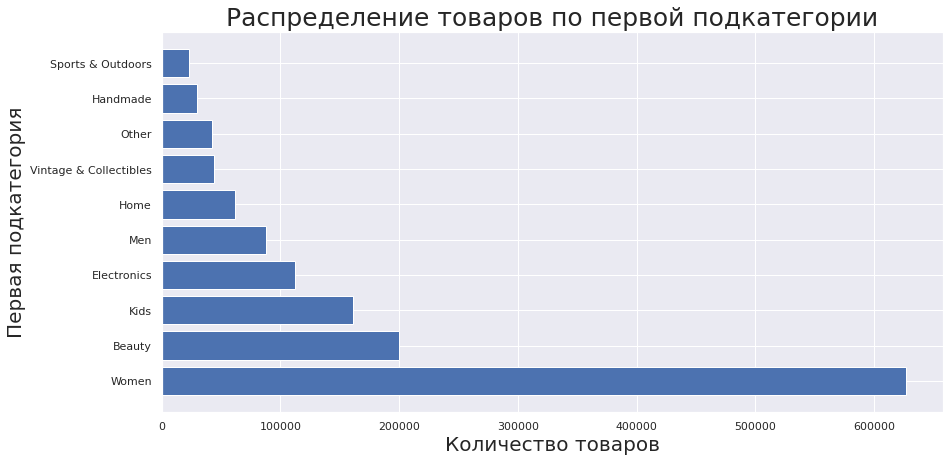

In [0]:
category1_count = Counter(data['category1'].values)
x, y = zip(*category1_count.most_common())
plt.figure(figsize=[14,7])
plt.barh(x, y)
plt.title('Распределение товаров по первой подкатегории', size = 25)
plt.xlabel('Количество товаров', size = 20)
plt.ylabel('Первая подкатегория', size = 20)
plt.show()

In [0]:
cat1_percent = []
for cat in data['category1'].unique():
    cat1_percent.append([cat, round(data[data['category1']==cat].shape[0]/data.shape[0]*100, 2)])
cat1_percent.sort(key=lambda x: x[1], reverse=True)
for x in cat1_percent:
    print(str(x[0]) + ': ' + (str(x[1]) + ' %')) 

Women: 45.1 %
Beauty: 14.39 %
Kids: 11.58 %
Electronics: 8.07 %
Men: 6.3 %
Home: 4.48 %
Vintage & Collectibles: 3.18 %
Other: 3.08 %
Handmade: 2.14 %
Sports & Outdoors: 1.67 %


Как можем заметить, подавляющее большинство товаров имеют первую подкатегорию Women.

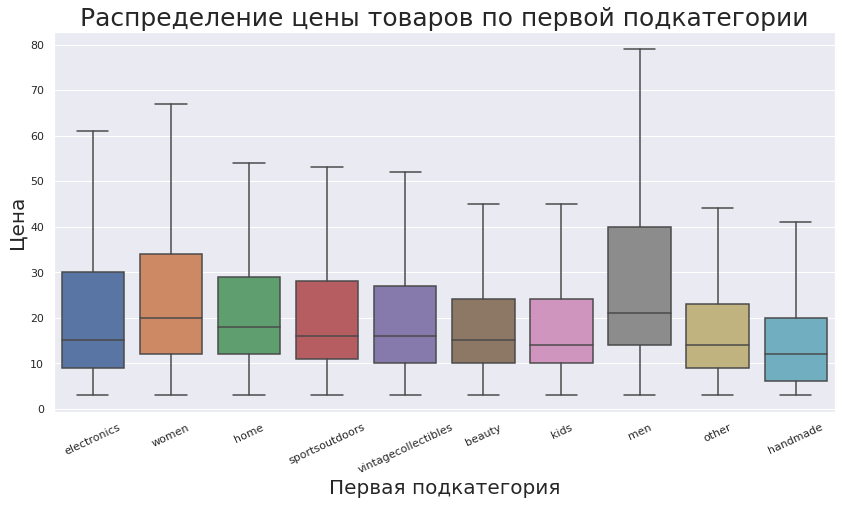

In [0]:
sns.set(style='darkgrid')
plt.figure(figsize=(14,7))
category1_distr = sns.boxplot(x='category1', y='price', data=data, showfliers=False)
category1_distr.set_xlabel('Первая подкатегория', fontsize=20)
category1_distr.set_ylabel('Цена', fontsize=20)
plt.xticks(rotation=25)
plt.title('Распределение цены товаров по первой подкатегории', size = 25)
plt.show()

Первые 10 вторых подкатегорий по популярности:

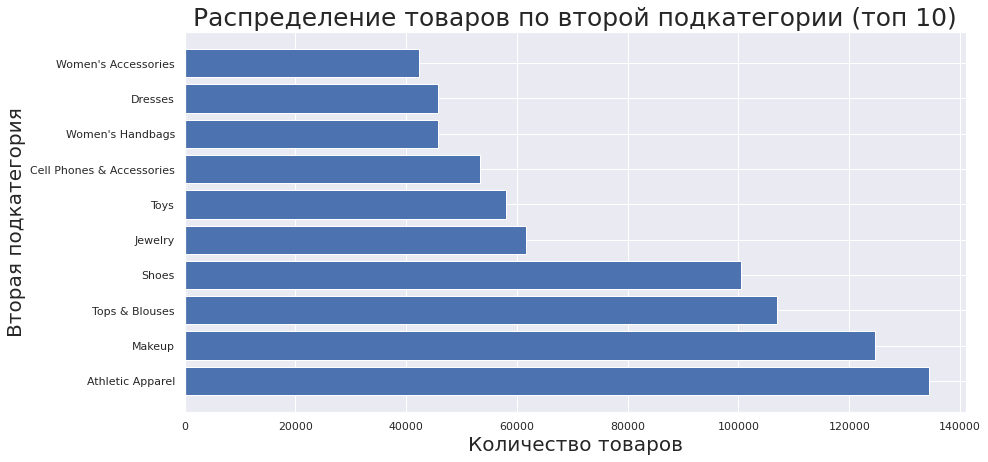

In [0]:
category2_count = Counter(data['category2'].values)
x, y = zip(*category2_count.most_common(10))
plt.figure(figsize=[14,7])
plt.barh(x, y)
plt.title('Распределение товаров по второй подкатегории (топ 10)', size = 25)
plt.xlabel('Количество товаров', size = 20)
plt.ylabel('Вторая подкатегория', size = 20)
plt.show()

In [0]:
cat2_percent = []
for cat in data['category2'].unique():
    cat2_percent.append([cat, round(data[data['category2']==cat].shape[0]/data.shape[0]*100, 2)])
cat2_percent.sort(key=lambda x: x[1], reverse=True)
for x in cat2_percent[:10]:
    print(str(x[0]) + ': ' + (str(x[1]) + ' %')) 

Athletic Apparel: 9.07 %
Makeup: 8.41 %
Tops & Blouses: 7.21 %
Shoes: 6.78 %
Jewelry: 4.17 %
Toys: 3.92 %
Cell Phones & Accessories: 3.6 %
Dresses: 3.09 %
Women's Handbags: 3.09 %
Women's Accessories: 2.86 %


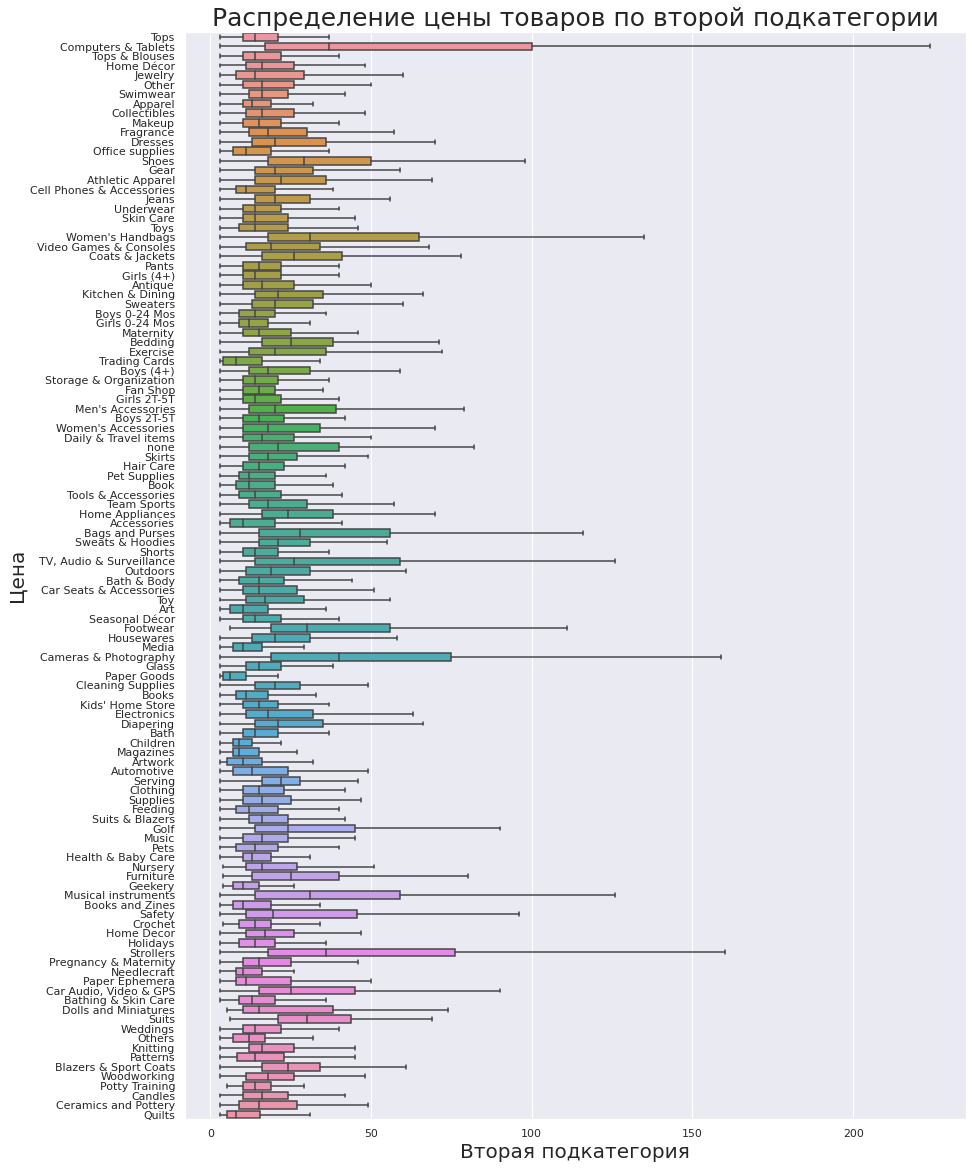

In [0]:
sns.set(style='darkgrid')
plt.figure(figsize=(14,20))
category2_distr = sns.boxplot(y='category2', x='price', data=data, showfliers=False)
category2_distr.set_xlabel('Вторая подкатегория', size=20)
category2_distr.set_ylabel('Цена', size=20)
plt.title('Распределение цены товаров по второй подкатегории', size = 25)
plt.show()

Первые 10 третьих подкатегорий по популярности:

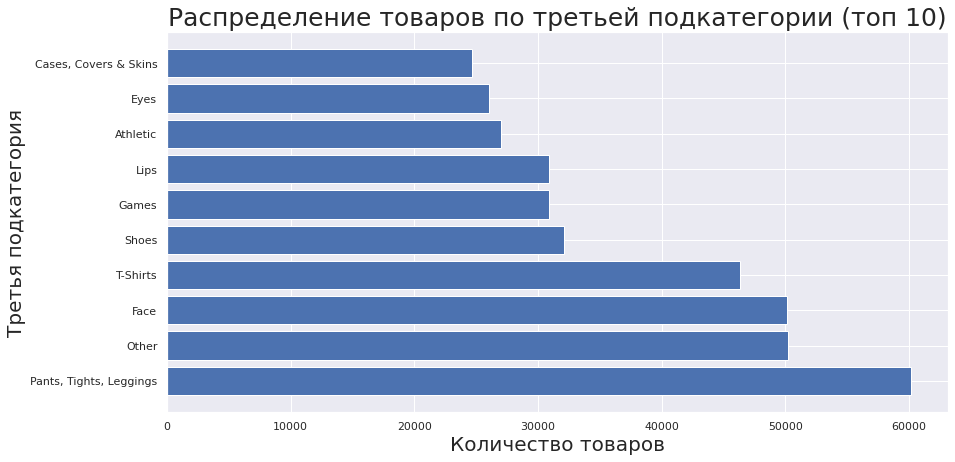

In [0]:
category3_count = Counter(data['category3'].values)
x, y = zip(*category3_count.most_common(10))
plt.figure(figsize=[14,7])
plt.barh(x, y)
plt.title('Распределение товаров по третьей подкатегории (топ 10)', size = 25)
plt.xlabel('Количество товаров', size = 20)
plt.ylabel('Третья подкатегория', size = 20)
plt.show()

In [0]:
cat3_percent = []
for cat in data['category3'].unique():
    cat3_percent.append([cat, round(data[data['category3']==cat].shape[0]/data.shape[0]*100, 2)])
cat3_percent.sort(key=lambda x: x[1], reverse=True)
for x in cat3_percent[:10]:
    print(str(x[0]) + ': ' + (str(x[1]) + ' %')) 

Pants, Tights, Leggings: 4.06 %
Other: 3.39 %
Face: 3.38 %
T-Shirts: 3.13 %
Shoes: 2.17 %
Games: 2.09 %
Lips: 2.08 %
Athletic: 1.82 %
Eyes: 1.76 %
Cases, Covers & Skins: 1.66 %


# Подготовка данных

Так как item_description и name содержат неструктурированные текстовые данные, то необходимо обработать их.

Удалим пунктуационные знаки, приведем слова к нижнему регистру и удалим стоп-слова(союзы, междометия, артикли и т.д.), которые не несут полезной информации, а являются лишь "шумом".

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from string import punctuation
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def delete_digits(x):
    return ''.join(ch for ch in x if not ch.isdigit())

def delete_punctuation(x):
    return ''.join(ch for ch in x if ch not in punctuation)

def delete_unnecessary_symbols(x):
    return ''.join(ch for ch in x if ch.isdigit() or ch.isalpha() or ch == ' ')

def to_lowercase(x):
    return x.lower()

def delete_stop_words(x):
    return ' '.join(w for w in x.split(' ') if w not in stop_words and w != 'rm')

def handle_category(x):
    x1 = x.replace(' ', '')
    x1 = to_lowercase(x1)
    return ''.join(ch for ch in x1 if ch.isdigit() or ch.isalpha())


In [0]:
# Очистка категорий от лишних символов
data['category1'] = data['category1'].apply(handle_category)
data['category2'] = data['category2'].apply(handle_category)
data['category3'] = data['category3'].apply(handle_category)

# Удаление цифр
#data['name'] = data['name'].apply(delete_digits)
#data['item_description'] = data['item_description'].apply(delete_digits)

# Удаление пунктуации
data['name'] = data['name'].apply(delete_punctuation)
data['item_description'] = data['item_description'].apply(delete_punctuation)

# Удаление остальных символов, которые не несут полезной информации
data['name'] = data['name'].apply(delete_unnecessary_symbols)
data['item_description'] = data['item_description'].apply(delete_unnecessary_symbols)

# Приведение слов к нижнему регистру
data['name'] = data['name'].apply(to_lowercase)
data['item_description'] = data['item_description'].apply(to_lowercase)
data['brand_name'] = data['brand_name'].apply(to_lowercase)

# Удаление стоп-слов
data['name'] = data['name'].apply(delete_stop_words)
data['item_description'] = data['item_description'].apply(delete_stop_words)

Также приведем все слова к единой форме, используя стеммер Портера. Он отсекает суффиксы и окончания, оставляя основу слова.

In [0]:
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()

def stem_words(x):
    return ' '.join(ps.stem(w) for w in x.split(' '))

data['item_description'] = data['item_description'].apply(stem_words)
data['name'] = data['name'].apply(stem_words)

После вышеописанных преобразований датасет выглядит следующим образом:

In [0]:
data.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,brand_is_defined,category1,category2,category3
0,1,razer blackwidow chroma keyboard,3,razer,52.0,0,keyboard great condit work like came box port ...,1,electronics,computerstablets,componentsparts
1,2,avaviv blous,1,target,10.0,1,ador top hint lace key hole back pale pink 1x ...,1,women,topsblouses,blouse
2,3,leather hors statu,1,none,35.0,1,new tag leather hors retail stand foot high so...,0,home,homedécor,homedécoraccents
3,4,24k gold plate rose,1,none,44.0,0,complet certif authent,0,women,jewelry,necklaces
4,5,bundl item request ruie,3,none,59.0,0,banana republ bottom candi skirt match blazera...,0,women,other,other


In [0]:
def empty_count(dataset, feature_name):
    if not feature_name in data.keys():
        return -1
    return len(dataset[dataset[feature_name] == ''])

In [0]:
for k in data.keys(): 
    print('В ' + k + ' ' + str(empty_count(data, k)) + ' пустых значений')

В train_id 0 пустых значений
В name 0 пустых значений
В item_condition_id 0 пустых значений
В brand_name 0 пустых значений
В price 0 пустых значений
В shipping 0 пустых значений
В item_description 0 пустых значений
В brand_is_defined 0 пустых значений
В category1 0 пустых значений
В category2 0 пустых значений
В category3 0 пустых значений


Удалим строки, содержащие пустые значения:

In [0]:
data = data[data.name != ''].reset_index(drop=True)
data = data[data.item_description  != ''].reset_index(drop=True)


In [0]:
#data.to_pickle('clean_data')
data = pd.read_pickle('clean_data')

Приведем категориальные признаки категорий товаров, бренда, состояний, типа доставки к числовому виду, используя One-hot кодирование. В результате этого кодирования каждому признаку будет соответствовать N новых бинарных признаков, где N — число категорий в этом признаке (единица на месте категории текущего признака и нули на всех остальных местах).

In [0]:
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(handle_unknown='ignore')
cat1_feature = oh.fit_transform(data['category1'].values.reshape(-1,1))
cat2_feature = oh.fit_transform(data['category2'].values.reshape(-1,1))
cat3_feature = oh.fit_transform(data['category3'].values.reshape(-1,1))
brand_feature = oh.fit_transform(data['brand_name'].values.reshape(-1,1))
brand_is_defined_feature = oh.fit_transform(data['brand_is_defined'].values.reshape(-1,1))
condition_feature = oh.fit_transform(data['item_condition_id'].values.reshape(-1,1))
shipping_feature = oh.fit_transform(data['shipping'].values.reshape(-1,1))

Приведем признак **name** из текстового вида в числовой, используя представление мешок слов с подсчётом числа вхождений слов в текущий документ.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=10, ngram_range=(1, 3), max_features=50000)
name_feature = cv.fit_transform(data['name'])

Приведем признак **item_description** из текстового вида в числовой, используя представление мешок слов с подсчётом частотности слов(чем чаще слово встречается во всём датасете - тем оно менее важно)).

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))
description_feature = tv.fit_transform(data['item_description'])

Объединеним наши полученные признаки вместе.

In [0]:
from scipy.sparse import hstack

sparse_data = hstack((cat1_feature, cat2_feature, cat3_feature, brand_feature, brand_is_defined_feature, condition_feature, shipping_feature, name_feature, description_feature)).tocsr()

In [0]:
sparse_data.shape

(1388393, 105707)

In [0]:
from scipy.sparse import save_npz, load_npz
#save_npz('sparse_data.npz', sparse_data)
sparse_data = load_npz('sparse_data.npz')

# Моделирование решений

Считаем log(p+1), где p - цена, для того, чтобы использовать среднеквадратичную логарифмическую ошибку при обучении.
$RMSE(y_i, ypred_i) = \sqrt{\frac{\sum_{i=1}^n(y_i - ypred_i))}{n}^2}$

$RMSLE(y_i, ypred_i) = \sqrt{\frac{\sum_{i=1}^n(log(y_i + 1) - log(ypred_i + 1))}{n}^2} = RMSE(log(y_i+1), log(ypred_i+1))$


In [0]:
prices = np.log1p(data['price'])

In [0]:
def rmse(y, yp):
    return np.sqrt(np.mean(np.power(y - yp, 2)))

Разделим датасет на две части для тренировки и тестирования.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sparse_data, prices, test_size=0.2, random_state=42)

Построим базовую наивную модель решения, которая будет предсказывать в качестве цены медиану всех цен в тренировочном наборе.
Затем посчитаем ошибку на тестовом наборе. Это значение будет служить некоей отправной точкой, которое мы будем улучшать.

In [0]:
baseline = np.median(y_train)
print('Базовое предсказание цены: ' + str(baseline))
print('Базовая RMSLE на тестовом наборе: ' + str(rmse(y_test, baseline)))

Базовое предсказание цены: 2.8903717578961645
Базовая RMSLE на тестовом наборе: 0.7495063183090014


1-я модель: SGDRegressor из библиотеки sklearn. Для подбора гиперпараметров использовался метод RandomizedSearchCV.

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor

sgdreg = SGDRegressor()
alpha = [10**i for i in range(-5,1)]
params = {'alpha': alpha}
rs = RandomizedSearchCV(sgdreg, param_distributions=params, scoring='neg_mean_squared_error', cv=4, random_state=42, n_jobs=-1, verbose=3)
start_time = time.time()
rs.fit(X_train, y_train)
print('Время подбора параметров: ', time.time() - start_time)
rs.best_params_

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.7min finished


Время подбора параметров:  113.65939402580261


{'alpha': 1e-05}

In [48]:
from sklearn.linear_model import SGDRegressor

sgdreg = SGDRegressor(alpha=rs.best_params_['alpha'], random_state=42)
start_time = time.time()
sgdreg.fit(X_train, y_train)
print('Время обучения: ', time.time() - start_time)
sgdreg_train_pred = sgdreg.predict(X_train)
start_time = time.time()
sgdreg_test_pred = sgdreg.predict(X_test)
print('Время работы: ', time.time() - start_time)
print('SGDRegressor train RMSLE: ' + str(rmse(y_train, sgdreg_train_pred)))
print('SGDRegressor test RMSLE: ' + str(rmse(y_test, sgdreg_test_pred)))

Время обучения:  9.176526546478271
Время работы:  0.050328731536865234
SGDRegressor train RMSLE: 0.4792223412172956
SGDRegressor test RMSLE: 0.48261537841537877


2-я модель: Ridge из библиотеки sklearn.

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge(solver="auto", random_state=42)
alpha = [0.1, 1, 2, 3, 4, 5] 
params = {'alpha': alpha}
rs = RandomizedSearchCV(ridge, param_distributions=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=3)
start_time = time.time()
rs.fit(X_train, y_train)
print('Время подбора параметров: ', time.time() - start_time)
rs.best_params_

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... alpha=0.1, score=-0.224, total= 2.8min
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[CV] .......................... alpha=0.1, score=-0.226, total= 2.7min
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s


[CV] .......................... alpha=0.1, score=-0.224, total= 2.5min
[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-0.225, total= 2.8min
[CV] alpha=1 .........................................................
[CV] ............................ alpha=1, score=-0.221, total= 1.9min
[CV] alpha=1 .........................................................
[CV] ............................ alpha=1, score=-0.222, total= 1.9min
[CV] alpha=1 .........................................................
[CV] ............................ alpha=1, score=-0.221, total= 1.9min
[CV] alpha=1 .........................................................
[CV] ............................ alpha=1, score=-0.222, total= 1.9min
[CV] alpha=2 .........................................................
[CV] ............................ alpha=2, score=-0.220, total= 1.7min
[CV] alpha=2 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 41.2min finished


Время подбора параметров:  2577.6495718955994


{'alpha': 5}

In [0]:
from sklearn.linear_model import Ridge

ridge = Ridge(solver="auto", random_state=42, alpha=rs.best_params_['alpha'])
start_time = time.time()
ridge.fit(X_train, y_train)
print('Время обучения: ', time.time() - start_time)
ridge_train_pred = ridge.predict(X_train)
start_time = time.time()
ridge_test_pred = ridge.predict(X_test)
print('Время работы: ', time.time() - start_time)
print('Ridge train RMSLE: ' + str(rmse(y_train, ridge_train_pred)))
print('Ridge test RMSLE: ' + str(rmse(y_test, ridge_test_pred)))

Время обучения:  73.2006983757019
Время работы:  0.038873910903930664
Ridge train RMSLE: 0.4259546908884462
Ridge test RMSLE: 0.4504869785518438


3-я модель: LightGBM



In [0]:
from lightgbm import LGBMRegressor
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

lgbm_regressor = LGBMRegressor() 
params = {'learning_rate': uniform(0, 1),
          'n_estimators': randint(500, 1500),
          'num_leaves': randint(50, 200),
          'max_depth': randint(5, 15),
         }

rs = RandomizedSearchCV(lgbm_regressor, param_distributions=params, n_iter=5, cv=3, scoring='neg_mean_squared_error', verbose=3)
start_time = time.time()
rs.fit(X_train, y_train)
print('Время подбора параметров: ', time.time() - start_time)
best_params = rs.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] learning_rate=0.39382137439638876, max_depth=5, n_estimators=1374, num_leaves=172 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.39382137439638876, max_depth=5, n_estimators=1374, num_leaves=172, score=-0.215, total=15.0min
[CV] learning_rate=0.39382137439638876, max_depth=5, n_estimators=1374, num_leaves=172 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.0min remaining:    0.0s


[CV]  learning_rate=0.39382137439638876, max_depth=5, n_estimators=1374, num_leaves=172, score=-0.215, total=14.2min
[CV] learning_rate=0.39382137439638876, max_depth=5, n_estimators=1374, num_leaves=172 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 29.2min remaining:    0.0s


[CV]  learning_rate=0.39382137439638876, max_depth=5, n_estimators=1374, num_leaves=172, score=-0.215, total=14.0min
[CV] learning_rate=0.3466933878928443, max_depth=10, n_estimators=686, num_leaves=130 
[CV]  learning_rate=0.3466933878928443, max_depth=10, n_estimators=686, num_leaves=130, score=-0.212, total=13.8min
[CV] learning_rate=0.3466933878928443, max_depth=10, n_estimators=686, num_leaves=130 
[CV]  learning_rate=0.3466933878928443, max_depth=10, n_estimators=686, num_leaves=130, score=-0.211, total=14.0min
[CV] learning_rate=0.3466933878928443, max_depth=10, n_estimators=686, num_leaves=130 
[CV]  learning_rate=0.3466933878928443, max_depth=10, n_estimators=686, num_leaves=130, score=-0.212, total=14.2min
[CV] learning_rate=0.9880877447153129, max_depth=6, n_estimators=908, num_leaves=102 
[CV]  learning_rate=0.9880877447153129, max_depth=6, n_estimators=908, num_leaves=102, score=-0.239, total=11.1min
[CV] learning_rate=0.9880877447153129, max_depth=6, n_estimators=908, num

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 254.8min finished


Время подбора параметров:  16659.52992272377


In [0]:
best_params

{'learning_rate': 0.36461294326501414,
 'max_depth': 12,
 'n_estimators': 761,
 'num_leaves': 128}

In [0]:
# best_params = {
#     'learning_rate': 0.36461294326501414,
#     'max_depth': 12,
#     'n_estimators': 761,
#     'num_leaves': 128
# }


In [0]:
from lightgbm import LGBMRegressor

lgbm_regressor = LGBMRegressor(**best_params, random_state=42, n_jobs=-1)
start_time = time.time()
lgbm_regressor.fit(X_train, y_train)
print('Время обучения: ', time.time() - start_time)
lgbm_train_pred = lgbm_regressor.predict(X_train)
start_time = time.time()
lgbm_test_pred = lgbm_regressor.predict(X_test)
print('Время работы: ', time.time() - start_time)
print('LGBMRegressor train RMSLE: ' + str(rmse(y_train, lgbm_train_pred)))
print('LGBMRegressor test RMSLE: ' + str(rmse(y_test, lgbm_test_pred)))

Время обучения:  1401.2543075084686
Время работы:  58.533897399902344
LGBMRegressor train RMSLE: 0.3980731525960036
LGBMRegressor test RMSLE: 0.44503088222793646


Добавим в датасеты предсказания Ridge и еще раз обучим LightGBM на получившихся данных.

In [0]:
from scipy.sparse import hstack

X_train_with_ridge_pred = hstack((X_train, ridge_train_pred.reshape(-1,1))).tocsr()
X_test_with_ridge_pred = hstack((X_test, ridge_test_pred.reshape(-1,1))).tocsr()

In [0]:
from lightgbm import LGBMRegressor

lgbm_regressor = LGBMRegressor(**best_params, random_state=42, n_jobs=-1)
start_time = time.time()
lgbm_regressor.fit(X_train_with_ridge_pred, y_train)
print('Время обучения: ', time.time() - start_time)
lgbm_train_pred = lgbm_regressor.predict(X_train_with_ridge_pred)
start_time = time.time()
lgbm_test_pred = lgbm_regressor.predict(X_test_with_ridge_pred)
print('Время работы: ', time.time() - start_time)
print('LGBMRegressor train RMSLE: ' + str(rmse(y_train, lgbm_train_pred)))
print('LGBMRegressor test RMSLE: ' + str(rmse(y_test, lgbm_test_pred)))

Время обучения:  1312.4135041236877
Время работы:  57.00734996795654
LGBMRegressor train RMSLE: 0.37899081716583527
LGBMRegressor test RMSLE: 0.43601191890368357


# Сравнение моделей

In [0]:
from prettytable import PrettyTable

x=PrettyTable()
x.field_names=["Модель", "Подбор гиперпараметров", "Обучение", "Время работы", "RMSLE на обучающей выборке", "RMSLE на тестовой выборке"]
x.add_row(["Baseline", "-", "-", "-", "-", "0.74950"])
x.add_row(["SGDRegressor", "2 мин", "8.3 сек", "0.05231 сек", "0.47922", "0.48261"])
x.add_row(["Ridge", "41.2 мин", "1.7 мин", "0.05109 сек", "0.42595", "0.45048"])
x.add_row(["LightGBM", "277.6 мин", "22.6 мин", "21.9 сек", "0.39807", "0.44503"])
x.add_row(["Ridge+LightGBM", "277.6 мин", "21.6 мин", "22.6 сек", "0.37899", "0.43601"])
print(x)

+----------------+------------------------+----------+--------------+----------------------------+---------------------------+
|     Модель     | Подбор гиперпараметров | Обучение | Время работы | RMSLE на обучающей выборке | RMSLE на тестовой выборке |
+----------------+------------------------+----------+--------------+----------------------------+---------------------------+
|    Baseline    |           -            |    -     |      -       |             -              |          0.74950          |
|  SGDRegressor  |         2 мин          | 8.3 сек  | 0.05231 сек  |          0.47922           |          0.48261          |
|     Ridge      |        41.2 мин        | 1.7 мин  | 0.05109 сек  |          0.42595           |          0.45048          |
|    LightGBM    |       277.6 мин        | 22.6 мин |   21.9 сек   |          0.39807           |          0.44503          |
| Ridge+LightGBM |       277.6 мин        | 21.6 мин |   22.6 сек   |          0.37899           |          0.4